# Random Time Version

## Theorem

Denote $\phi^T(t)$ be the probability of a person getting cancer before time $T-t$ (condition same as in simulation, start with 0 age, 0 mutation and end at time $T-t$). $q_G^T(t)$ the same as in your theory (where $T$ is the total time). 

Let $T_1$ be the hit time of first mutation. From the hypothesis of branching process approximation and real parameter, we know that basically only type "F" mutation will survive and we can assume the conditional probability of first mutation be "F" is 1/3.

Let $T_2$ be the time for the mutated cell to grow to size $\epsilon K$ condition on the cell population will survive. Then we use the same approximation as in your theorem, which is $f_{T_2}(t) = \frac{r^2 e^{-rt} \epsilon K}{b} \exp\left( -\frac{re^{-rt}\epsilon K}{b} \right)$. And the survival probability is $\frac{r}{b}$.

Then we have:
$$\phi^T(t) = \frac{1}{3} E\left[ \frac{r_{F}}{b_{F}} (1-q^T_F(t+T_1+T_2)) \right]$$

which is 
$$\phi^T(t) = \frac{1}{3|T_1|}\sum_{T_1}\int \frac{r_{F}}{b_{F}} (1-q^T_F(t+T_1+t_2)) f_{T_2}(t_2) dt_2$$


## Experiment

### Parameter setting:

Excess Survival ratio: 0.12266612081232287
P(mutiation in [0,tao]): 0.0894557402361339


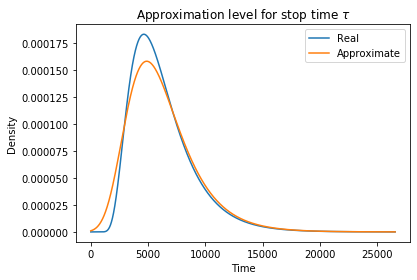

Survival Rate:  0.004069157973642593
{'b': 0.10546777119374999, 'd': 0.10503860617163463, 'r': 0.00042916502211536034, 'K': 1995262314.9688828, 'G': 'S', 'va': 7.5e-09, 'vs': 1.5e-08, 'v': 7.537499999999999e-09}
{'division': 1.75, 'death': 0.009615384615384616, 'pasym': 0.9, 'psym': 0.0525, 'dsym': 0.04750000000000001, 'adjust': 0.015, 'v': 1e-06, 'K': 1995262314.9688828, 'dd': 1.14794853, 'dp': 0.0021200000000000004, 'dm': 4.9999999999999996e-06, 'l_ratio': 0.08571428571428572, 'pow': 0.4117, 'eps': 1e-06}


In [21]:
from theorem import *

%matplotlib inline

alpha = {"division":1.75, "death":1/104, "pasym":0.9, "psym":0.0525, "dsym":0.1-0.0525,
         "adjust":1.5e-2, "v":1e-6, "K":10**9.3, "dd":1.14794853, "dp":2.12*1e-3, "dm":5*1e-6,
         "l_ratio":0.15/(1.6+0.15), "pow":0.4117, "eps":1e-6}

test = tissue(alpha, pGUfunc, 52*80,52*80*10, Gene="S")
density = test.density(test.ts, test.para)
print("Survival Rate: ", test.para["r"] / test.para["b"])
print(test.para)
print(test.alpha)

When detected a mutation grown to size 100, then this lineage will basically survive (over 99.9% likely), which means first hit time in simulation is "the time for first survival hit" + "time for that cell lineage grow to size 100".

### Here we shows the time distribution of mutated cell grow to size $\epsilon K$ using branching process approximation, and you can see we can have an about 15 year range of uncertainty

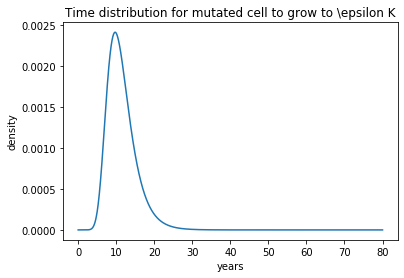

In [14]:
plt.plot(test.ts/52, density, label='Line 1')
plt.xlabel("years")
plt.ylabel("density")
plt.title("Time distribution for mutated cell to grow to \epsilon K")
plt.show()

### solving for theoretical result

In [26]:
r_F = test.para["r"]
b_F = test.para["b"]
print("Survial Probability for mutated cell:", r_F/b_F)
solution = test.solve()

Survial Probability for mutated cell: 0.06857368190213298
Begin Solving
F  FS  FSS  FSF  FSM  FF  FFS  FFF  FFM  FM  FMS  FMF  FMM  
Done


### Here's the empirical distribution for HitTime1 and you can see after using this as our first hit time distribution in our theoretical computation, we can have an about 30 year uncertainty further. Together with uncertainty above we can have enough uncertainty in final result.

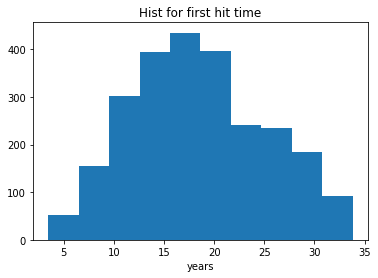

In [27]:
import pandas as pd

result = pd.read_csv("result.csv")
hit1 = np.array(pd.to_numeric(result[' HitTime1'], errors="coerce").to_list())
hit1 = hit1[~np.isnan(hit1)]
plt.hist(hit1/52)
plt.xlabel("years")
plt.title("Hist for first hit time")
plt.show()

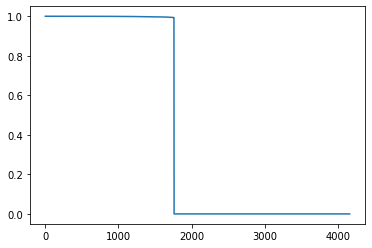

In [49]:
surv = np.zeros(80*52)
for i in range(80*52):
    surv[i] = np.mean(hit1>=i)
plt.plot(list(range(80*52)), surv**(1/1000))
plt.show()

### Embedding the random first hit time

In [42]:
hit1.shape, solution["F"].shape, max(hit1), 41600/52

((2486,), (41600,), 1758.0, 800.0)

In [43]:
import numba as nb

# adjust_density = 1/3 * 0.1 * r_F/b_F * density / len(hit1)
# solutionF = solution["F"][::10]
# adjust_density = adjust_density[::10]*10

# @nb.njit 
# def aux(solutionF, hit1, adjust_density):
#     prob = np.zeros(solutionF.shape[0])
#     for i in range(len(solutionF)):
#         if i % 400 == 0:
#             print(i)
#         for t1 in hit1:
#             j = int(t1)
#             for k, d_t2 in enumerate(adjust_density):
#                 if i + j + k < len(prob):
#                     prob[i] += d_t2 * (1-solutionF[i+j+k])
#     print("")
#     return prob

solutionF = solution["F"][::10]

@nb.njit 
def aux(solutionF, hit1):
    prob = np.zeros(solutionF.shape[0])
    for i in range(len(solutionF)):
        if i % 400 == 0:
            print(i)
        for t1 in hit1:
            j = int(t1)
            if i + j < len(prob):
                prob[i] += (1-solutionF[i+j]) / len(hit1)
    print("")
    return prob

# prob = aux(solutionF, hit1, adjust_density)
prob = aux(solutionF, hit1)

0
400
800
1200
1600
2000
2400
2800
3200
3600
4000



### Here is the cancer probability for one cell lineage. 

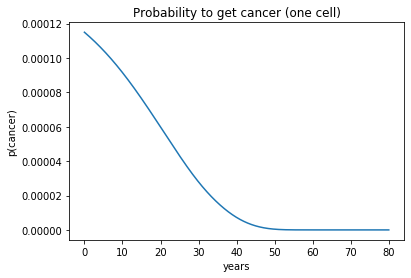

In [46]:
plt.plot(test.ts[::10]/52, prob, label='Line 1')
plt.xlabel("years")
plt.ylabel("p(cancer)")
plt.title("Probability to get cancer (one cell)")
plt.show() 

### Then we can see to get an about 0.04 initial cancer probability, we can tolerant about 3000 independent cell lineage and since cells are far away from independent, we can tolerant more lineage in real life. 

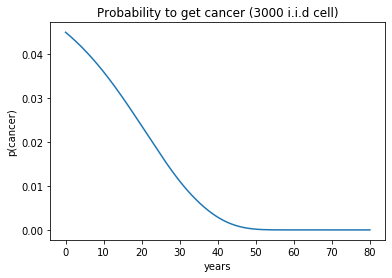

In [33]:
plt.plot(test.ts[::10]/52, 1-(1-prob)**400, label='Line 1')
plt.xlabel("years")
plt.ylabel("p(cancer)")
plt.title("Probability to get cancer (3000 i.i.d cell)")
plt.show() 